# BILSTM - MAX_LEN 500 - EMBEDDINGS OWN - TEST_ACC 99.77

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential,Model
from keras.layers import Input,Embedding,Bidirectional,LSTM,TimeDistributed,Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard,ReduceLROnPlateau

## PreProcess Data

In [4]:
def process_csv(csv):
    df = pd.read_csv(csv)
    df=df.drop(columns=['Case','lemma', 'Gender','Number','State','Gloss','Proclitic 1','Proclitic 2','Proclitic 0','Aspect','Mood','Person','Voice','Enclitic 0'])
    df=df.drop_duplicates()
    df["POS"] = df["POS"].apply(lambda x: x.replace("Proper Noun", "ProperNoun"))
    df1 = pd.DataFrame(columns = ['x','y'])
    for i in df['sentence_id'].unique():
        df1 = df1.append({'x':df[df['sentence_id'] == i]['word'].tolist() , 'y':df[df['sentence_id'] == i]['POS'].tolist()}, ignore_index=True)
    return df1

In [6]:
csvs = ['description_mor.csv', 'title_mor.csv']
final_df = pd.DataFrame()
for csv in csvs:
    df = process_csv('Dataset/'+csv)
    final_df = pd.concat([final_df,df])
final_df = final_df.sample(frac = 1)
final_df.reset_index(drop=True, inplace=True)
final_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,x,y
0,"[1831, منشأة, فندقية, وسياحية, حصلوا, على, الش...","[Digit, Noun, Adjective, Adjective, Verb, Prep..."
1,"[أمير, الكويت, يعزى, الرئيس, السيسى, فى, وفاة,...","[Noun, ProperNoun, Verb, Noun, ProperNoun, Pre..."
2,"[العربية, :, القصف, الذى, طال, حزب, الله, استه...","[Adjective, Punctuation, Noun, Relative Pronou..."
3,"[وزيرة, الدفاع, الفرنسية, :, 3, مقاتلات, رافال...","[Noun, Noun, Adjective, Punctuation, Digit, No..."
4,"[رغم, انخفاض, الإقبال, على, هاتفى, أيفون, 8, و...","[Noun, Noun, Noun, Preposition, Adjective, Pro..."


In [7]:
embedding_dim = 300
MAX_SEQUENCE_LENGTH = 500

In [8]:
x_tokenizer = Tokenizer(oov_token = "<OOV>")                    
x_tokenizer.fit_on_texts(final_df['x'].tolist())  
VOCABULARY_SIZE = len(x_tokenizer.word_index) + 1                  
x = x_tokenizer.texts_to_sequences(final_df['x'].tolist())  

In [9]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(final_df['y'].tolist())
y = y_tokenizer.texts_to_sequences(final_df['y'].tolist())

In [10]:
x = pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y = pad_sequences(y, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y = to_categorical(y)

In [11]:
x_train = np.array(x[:int(len(x)*0.7)])
x_val = np.array(x[int(len(x)*0.7):int(len(x)*0.9)])
x_test = np.array(x[int(len(x)*0.9):])
assert len(x_train)+len(x_val)+len(x_test) == len(x)

In [12]:
y_train = np.array(y[:int(len(y)*0.7)])
y_val = np.array(y[int(len(y)*0.7):int(len(y)*0.9)])
y_test = np.array(y[int(len(y)*0.9):])
assert len(y_train)+len(y_val)+len(y_test) == len(y)

In [13]:
print("Training data shape (x y) ", x_train.shape,y_train.shape)
print("Validation data shape (x y) ", x_val.shape,y_val.shape)
print("Test data shape (x y) ", x_test.shape,y_test.shape)

Training data shape (x y)  (10000, 500) (10000, 500, 33)
Validation data shape (x y)  (2858, 500) (2858, 500, 33)
Test data shape (x y)  (1429, 500) (1429, 500, 33)


## Embedding Matrix

In [ ]:
!wget https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
!unzip full_grams_cbow_300_twitter.zip

In [ ]:
import gensim
embedding_model = gensim.models.Word2Vec.load('full_grams_cbow_300_twitter.mdl')
embeddings = {}
for word,vector in zip(embedding_model.wv.vocab,embedding_model.wv.vectors):
    coefs = np.array(vector, dtype='float32')
    embeddings[word] = coefs
embeddings_weights = np.zeros((VOCABULARY_SIZE, embedding_dim))
for word, i in x_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

## Create Model

In [14]:
tagger = Sequential()
tagger.add(Input((MAX_SEQUENCE_LENGTH)))
tagger.add(Embedding(input_dim = VOCABULARY_SIZE,output_dim = embedding_dim, input_length  = MAX_SEQUENCE_LENGTH,#weights = [embeddings_matrix],
                             trainable = True))
tagger.add(Bidirectional(LSTM(256, return_sequences=True)))
tagger.add(Bidirectional(LSTM(256, return_sequences=True)))
tagger.add(Bidirectional(LSTM(256, return_sequences=True)))
tagger.add(Bidirectional(LSTM(256, return_sequences=True)))
tagger
tagger.add(TimeDistributed(Dense(y.shape[2], activation='softmax')))
tagger.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
tagger.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          9859500   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 512)          1140736   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 512)          1574912   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 512)          1574912   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 500, 512)          1574912   
_________________________________________________________________
time_distributed (TimeDistri (None, 500, 33)           16929     
Total params: 15,741,901
Trainable params: 15,741,901
Non-trainable params: 0
____________________________________________

## Train Model

In [15]:
checkpoint = ModelCheckpoint('model2_checkpoint.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='min' , min_lr=0.0001)

In [16]:
result = tagger.fit(x_train, y_train, validation_data= (x_val, y_val), epochs = 40, batch_size= 128, shuffle = True,callbacks=[checkpoint,reducelr])

Epoch 1/40
79/79 [==============================] - 113s 1s/step - loss: 0.4526 - accuracy: 0.9133 - val_loss: 0.0677 - val_accuracy: 0.9800

Epoch 00001: val_accuracy improved from -inf to 0.98002, saving model to model1_checkpoint.h5
Epoch 2/40
79/79 [==============================] - 81s 1s/step - loss: 0.0664 - accuracy: 0.9806 - val_loss: 0.0650 - val_accuracy: 0.9814

Epoch 00002: val_accuracy improved from 0.98002 to 0.98143, saving model to model1_checkpoint.h5
Epoch 3/40
79/79 [==============================] - 81s 1s/step - loss: 0.0636 - accuracy: 0.9817 - val_loss: 0.0636 - val_accuracy: 0.9815

Epoch 00003: val_accuracy improved from 0.98143 to 0.98149, saving model to model1_checkpoint.h5
Epoch 4/40
79/79 [==============================] - 81s 1s/step - loss: 0.0621 - accuracy: 0.9816 - val_loss: 0.0616 - val_accuracy: 0.9815

Epoch 00004: val_accuracy improved from 0.98149 to 0.98155, saving model to model1_checkpoint.h5
Epoch 5/40
79/79 [==============================] 

## Evaluate Model

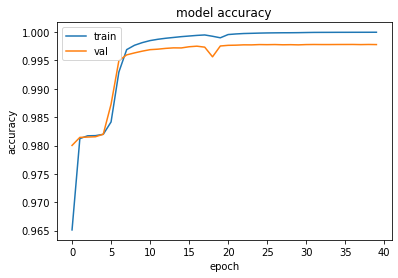

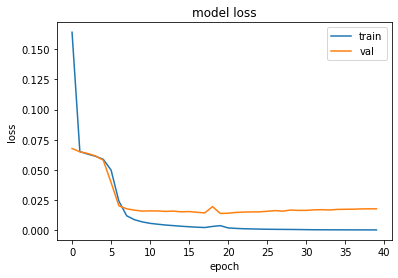

In [17]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper right')
plt.show()

In [18]:
tagger.load_weights('model2_checkpoint.h5')

In [19]:
loss, accuracy = tagger.evaluate(x_test, y_test)
print('Loss:',loss)
print('Accuracy:',accuracy)

45/45 [==============================] - 6s 126ms/step - loss: 0.0182 - accuracy: 0.9977
Loss: 0.01816359907388687
Accuracy: 0.9977452754974365


## Predict 

In [20]:
def pos_tagger(sent):
    words = sent.split()
    words = [x_tokenizer.texts_to_sequences(words)]
    words = pad_sequences(words, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
    words = np.squeeze(words,axis=-1)
    tags = np.squeeze(tagger.predict(words).argmax(-1))
    tags = [y_tokenizer.index_word[tag] for tag in tags if tag != 0]
    return tags

In [21]:
sentence = "جون يحب البيت الأزرق في نهاية الشارع"
output = pos_tagger(sentence)
pred_tags = [(sentence.split()[i],output[i]) for i in range(len(sentence.split()))]
for w,t in pred_tags:
    print(w,t)

جون propernoun
يحب noun
البيت noun
الأزرق noun
في preposition
نهاية noun
الشارع noun


## Evaluate Prediction

In [23]:
from evaluate_pred import *
evaluate(sentence, pred_tags)

85.71428571428571